In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
import nltk
import tensorflow as tf
from math import log
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

In [2]:
# Load and preprocess dataset
data_path = "/Users/celinewu/Documents/GitHub/2024-25c-fai2-adsai-group-group16/Data/cropped_df.csv"
df = pd.read_csv(data_path)

# Drop missing or empty labels
df = df.dropna(subset=["main_category"])
df = df[df["main_category"].str.strip() != ""]

# rename main_category
df.rename(columns={"main_category": "label"}, inplace=True)


In [3]:
# Perform text augmentation
nltk.download('averaged_perceptron_tagger')
augmenter = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2, aug_p=0.1)

def augment_data(df, text_col, label_col, augmenter):
    class_counts = df[label_col].value_counts()
    max_samples = class_counts.max()
    augmented_data = []
    
    for label, count in class_counts.items():
        label_df = df[df[label_col] == label]
        augmented_data.append(label_df)
        
        if count < max_samples:
            additional_samples = max_samples - count
            sampled_df = label_df.sample(n=additional_samples, replace=True, random_state=42)
            augmented_texts = [augmenter.augment(text) if text else text for text in sampled_df[text_col]]
            augmented_df = pd.DataFrame({text_col: augmented_texts, label_col: label})
            augmented_data.append(augmented_df)
    
    return pd.concat(augmented_data, axis=0).reset_index(drop=True)

balanced_df = augment_data(df, "text", "label", augmenter)


[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>


In [4]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(balanced_df["label"])
num_classes = len(label_encoder.classes_)

# Tokenization and padding
max_words = 10000
max_seq_len = 30

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df["text"])

X_sequences = tokenizer.texts_to_sequences(balanced_df["text"])
X_padded = pad_sequences(X_sequences, maxlen=max_seq_len, padding='post')


In [5]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights
class_weights = {label: log(1 + (len(y_train) / (num_classes * count))) for label, count in zip(*np.unique(y_train, return_counts=True))}


In [6]:
# Define RNN model
embedding_dim = 128
rnn_units = 128
dropout_prob = 0.5

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_len),
    SimpleRNN(rnn_units, return_sequences=True, activation='relu'),
    Dropout(dropout_prob),
    SimpleRNN(rnn_units, activation='relu'),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax')
])


/Users/celinewu/anaconda3/envs/2B/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-26 09:30:44.985493: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-03-26 09:30:44.985514: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-26 09:30:44.985517: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-26 09:30:44.985732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 09:30:44.985746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefin

In [7]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_seq_len))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,695 (5.14 MB)

 Trainable params: 1,346,695 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('rnn_emotion_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/35


2025-03-26 09:30:45.594837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1003s 864ms/step - accuracy: 0.2602 - loss: 1.1450 - val_accuracy: 0.3840 - val_loss: 1.4119
Epoch 2/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 997s 859ms/step - accuracy: 0.4220 - loss: 0.9176 - val_accuracy: 0.3241 - val_loss: 1.4971
Epoch 3/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 999s 861ms/step - accuracy: 0.4611 - loss: 0.8849 - val_accuracy: 0.5864 - val_loss: 0.9741
Epoch 4/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1002s 864ms/step - accuracy: 0.6220 - loss: 0.6506 - val_accuracy: 0.6680 - val_loss: 0.8623
Epoch 5/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 999s 861ms/step - accuracy: 0.6549 - loss: 0.5951 - val_accuracy: 0.5665 - val_loss: 0.9999
Epoch 6/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1003s 865ms/step - accuracy: 0.6376 - loss: 0.5785 - val_accuracy: 0.6524 - val_loss: 0.8396
Epoch 7/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 998s 861ms/step - accuracy: 0.6785 - loss: 0.5215 - val_accuracy: 0.6569 - val_loss: 0.9560
Epoch 8/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1007s 868ms/step - accuracy:

In [9]:
# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

y_preds = np.argmax(model.predict(X_val), axis=1)
f1_macro = f1_score(y_val, y_preds, average='macro')
print(f"Macro F1 Score: {f1_macro:.4f}")


290/290 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.7005 - loss: 0.7871
Validation Loss: 0.8227
Validation Accuracy: 0.7033
290/290 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step
Macro F1 Score: 0.6798


In [10]:
# Display classification report
print("Classification Report:\n", classification_report(y_val, y_preds, target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

       anger       0.96      0.73      0.83      1325
     disgust       0.98      1.00      0.99      1325
        fear       0.70      0.75      0.73      1325
   happiness       0.38      0.10      0.15      1325
     neutral       0.72      0.97      0.83      1325
     sadness       0.43      0.87      0.58      1325
    surprise       0.90      0.51      0.65      1325

    accuracy                           0.70      9275
   macro avg       0.73      0.70      0.68      9275
weighted avg       0.73      0.70      0.68      9275



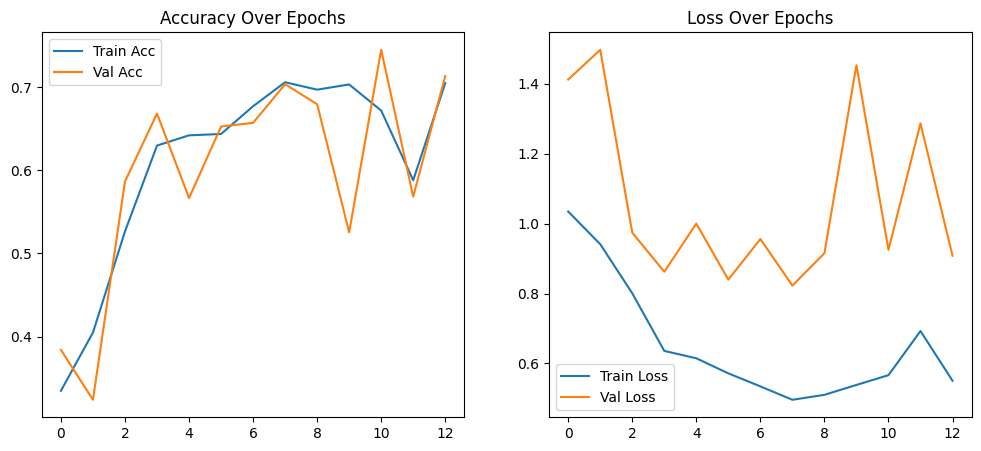

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

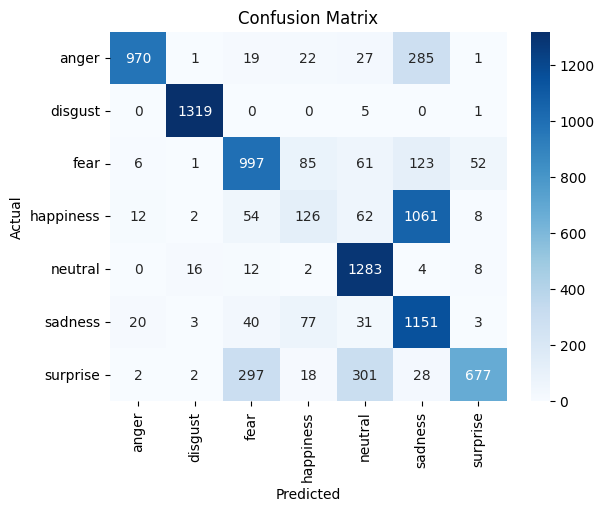

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save("1rnn_emotion_model.keras")


In [13]:
# Load test set from Excel file
test_df = pd.read_excel("/Users/celinewu/Documents/GitHub/2024-25c-fai2-adsai-group-group16/Data/group 16_url1.xlsx")  # ← replace with your file path
test_df = test_df.dropna(subset=["label"])
test_df = test_df[test_df["label"].str.strip() != ""]

# Encode test labels using the same label encoder
y_test = label_encoder.transform(test_df["label"])

# Tokenize and pad test text using the same tokenizer and max_seq_len
X_test_seq = tokenizer.texts_to_sequences(test_df["text"])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post')

# Predict on test set
y_test_probs = model.predict(X_test_pad)
y_test_preds = np.argmax(y_test_probs, axis=1)


KeyError: ['label']

In [ ]:
print("\n=== TEST SET EVALUATION ===")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision (macro):", precision_score(y_test, y_test_preds, average='macro'))
print("Recall (macro):", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_test_preds, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_test_preds, target_names=label_encoder.classes_))


In [ ]:
# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_preds)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()